# Financial Econometrics 2 - Project 1
## Jan Kubal & Matyáš Mattanelli
### Instructions

**Part A)**

0) We ask you to create a folder for you project, in which you will be working on the project. You will be asked to send us this project that we can look at your progress and browse through your work. Please follow the instructions in the seminar or a documentation of julia about the activation of an environment and use it for your project. (It can be found also here: https://pkgdocs.julialang.org/v1/environments/ even it is from prompt/terminal, in a notebook use `Pkg.activate(".")`) 
* In your project, you will be adding packages, using them, you can create a script files as well and load them (with helper functions if needed.)


1) Use package `MarketData`, `Quandl`, or different one, if needed go to their github pages and `docs`, then **download data for an asset** of your choice.
2) Use plot to look at the data, do some summary statistics, `Statistics`, `DataFrames`, `StatsPlots` packages
3) Use GARCH to **model** asset data and **forecast**.
3) **Plot** forecasts.
    
This part is for you to get you familiar with julia, its syntax, and pacakges.

**Part B)**
- *OLS* vs *ML* estimation HAR
    - Estimate coefficients with different approaches
    - Optim.jl vs Flux.jl
    - Discuss coefficients, show them in scatter, histograms
    - test different activations in NN
    - play around with regularizations
    - Make Q-Q plots, a table of performance

**Part C)**
- Find a dataset or time-series and do the prediction task employing methods (not neccesarily all of them) we covered during lectures L1-L6 (next week)
    - It can be cross-sectional finance example
    - OR forecasting time-series (maybe preferably)
- Use ensemble technique/averaging in final predictions when use neural network models
- Use performance measures
- As an example, and also a wrap-up of NN techniques, you can consult different papers in the literature.
    - Papers on forecasting:
        - Babiak & Barunik (2020) contains NN section and uses Goyal & Welch in forecasting part [arxiv](https://arxiv.org/abs/2009.03394)
        - Feng et al. (2018) Deep Learning for Predicting Asset Returns (https://arxiv.org/pdf/1804.09314.pdf)    
    - Papers on distribution (both predict parameters of distribution):
        - Salinas et al. (2019): DeepAR [pdf](https://arxiv.org/pdf/1704.04110v3.pdf), [python](https://paperswithcode.com/paper/deepar-probabilistic-forecasting-with)
        - Weron et al. (2022): Distributional neural networks for electricity prices forecasting [arxiv pdf](https://arxiv.org/abs/2207.02832)
        - CHALLENGING - to replicate one of the two :) (definitely not necessary)

---

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


#### Loading required packages

In [3]:
#Load required packages
import Dates
import MarketData
import Statistics
import Plots
import DataFrames
import StatsPlots
import StatsBase
import ARCHModels
import LinearAlgebra
import CSV
import Optim
import Random
import Flux

include("utils.jl") #A file containing functions taken from the seminar + custom defined functions

[> Loaded d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1\utils.jl


## Part A)

### 1.

We have chosen the McDonald's stock price as the variable of interest. We will download it from Yahoo Finance. We acquire only 10 years worth of data (January 2012 - December 2021) since ancient history may not have relevance for the present, in fact, it may adversely affect the forecasts.

In [3]:
#Download data for McDonald's stock from Yahoo (42.2s)
t1 = Dates.DateTime(2012, 1, 1) #Starting period
t2 = Dates.DateTime(2022, 1, 1) #Ending period
MCD = MarketData.yahoo("MCD", MarketData.YahooOpt(period1 = t1, period2 = t2));

We are interested only in the adjusted close price so we will store it in a variable. We also calculate the log-returns since we do not expect the price to be stationary.

In [4]:
#Store only the Adjusted Close price
MCD_adj_close = MarketData.values(MCD[:AdjClose])

#Calculate log-returns
MCD_log_ret = diff(log.(MCD_adj_close));

### 2.

In this section we provide some fundamental summary statistics.

In [5]:
#Define function for summary statistics
n(x) = size(x)[1] #Define a function calculating the number of observations
quantile_5(x) = Statistics.quantile(x, 0.05) #Define a function calculating the 5th percentile
quantile_25(x) = Statistics.quantile(x, 0.25) #Define a function calculating the 25th percentile
quantile_75(x) = Statistics.quantile(x, 0.75) #Define a function calculating the 75th percentile
quantile_95(x) = Statistics.quantile(x, 0.95) #Define a function calculating the 95th percentile
sum_stats = [n, Statistics.mean, Statistics.std, quantile_5, quantile_25, Statistics.median, quantile_75, quantile_95, StatsBase.skewness, StatsBase.kurtosis] #Store the functions caclulating summary statistics into a vector for looping
str_info = ["Number of observations: ", "Mean: ", "Standard deviation: ", "5th percentile: ", "25th percentile: ", "Median: ", "75th percentile: ", "95th percentile: ", "Skewness: ", "Kurtosis: "] #Define strings to be printed

#Print summary statistics for raw price
println("Raw price")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_adj_close), digits = 2)))
end

#Print summary statistics for log-returns
println("")
println("Log-returns")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_log_ret), digits = 2)))
end


Raw price


Number of observations: 2517.0
Mean: 129.33
Standard deviation: 54.89


5th percentile: 68.85
25th percentile: 77.23
Median: 108.6
75th percentile: 175.74
95th percentile: 228.27
Skewness: 0.54
Kurtosis: -1.03

Log-returns
Number of observations: 2516.0
Mean: 0.0
Standard deviation: 0.01
5th percentile: -0.02
25th percentile: -0.0
Median: 0.0
75th percentile: 0.01
95th percentile: 0.02
Skewness: -0.19
Kurtosis: 37.56


The summary statistics suggest that the price is slightly positively skewed and platykurtic. On the other hand, the returns appear to be more symmetric (even though slightly negatively skewed) and with very heavy tails (high kurtosis). The average return is roughly zero (measured by both the mean and the median) so in general the distribution of the returns does not deviate from our expectations.

We can also plot the time series of the prices as well as returns. We can see that there is an obvious trend in price and as is common for asset prices, the time series is far from stationary. There appears to be a significant drop in price around the year 2020 very likely caused by the coronavirus pandemic.

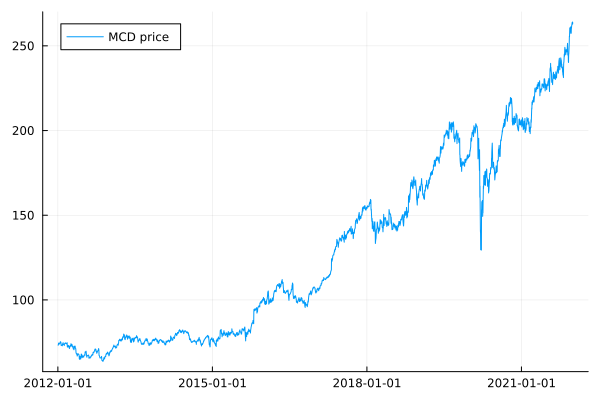

In [6]:
#Plotting the time series of price
Plots.plot(MCD[:AdjClose], labels = "MCD price", legend = :topleft)

On the other hand, the returns appear to be mean-stationary. However, we can observe some large variance clusters. Once again, especially around the time of the Covid-19 outbreak.

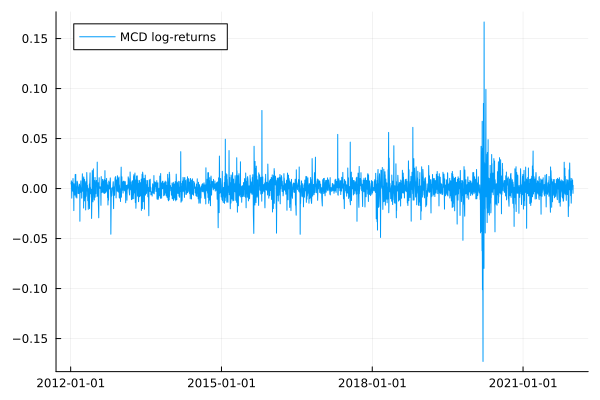

In [7]:
#Plotting the time series of log-returns
Plots.plot(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns", legend = :topleft)

The inspection of histogram may give an insight into the shape of a distribution of a variable. As we can see, the histogram of MCD price below indicates that the series is positively skewed. This corresponds to the positive skewness calculated in the summary statistics.

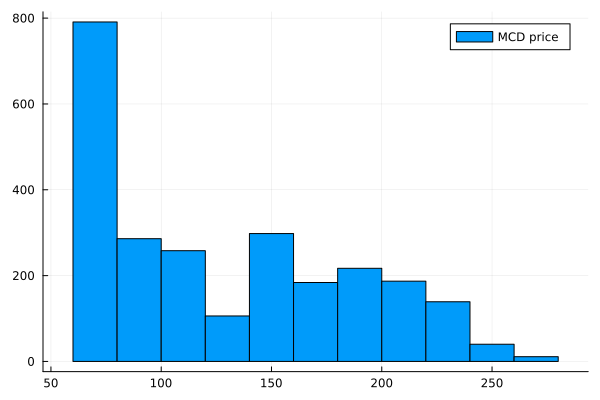

In [8]:
#Plot histogram of price
Plots.histogram(MCD[:AdjClose], labels = "MCD price")

On the other hand, the returns appear to be symmetric and with very heavy tails.

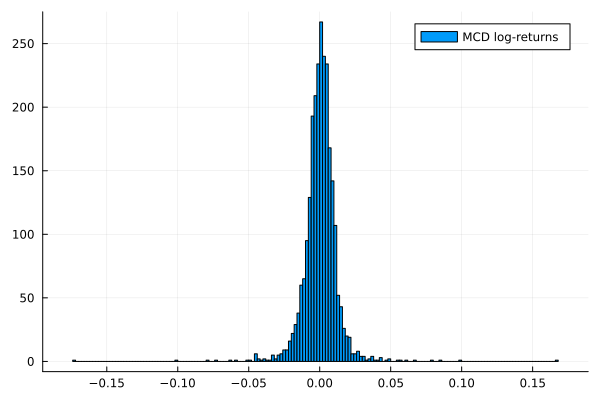

In [9]:
#Plot histogram of log-returns
Plots.histogram(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns")

#### 3. 

In this section we estimate a GARCH model using the returns on the MCD's asset. We use the ``ARCHModels`` package rather than ``GARCH`` due to the incompability of ``GARCH`` with ``Flux`` which is a package used in subsequent parts. Firstly, we will inspect the dependencies in the returns by plotting the Autocorrelation function (ACF).

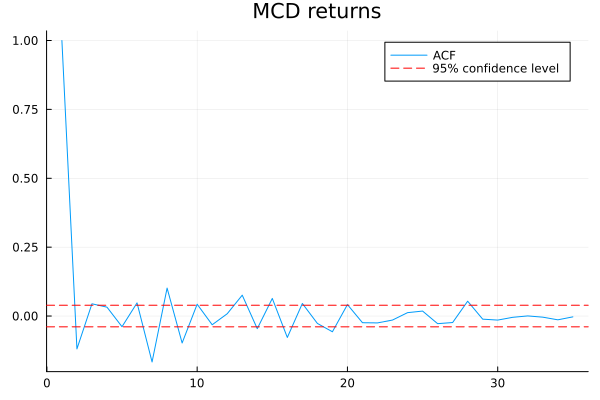

In [10]:
#Plot ACF
plot_ACF(MCD_log_ret, "MCD returns")

As we can see, there appear to be some significant dependencies in the returns. Arguably, these could be modelled using purely GARCH but we will try an ARMA model first and see the results. We will start with a simple AR(1) model.

In [11]:
#Fit AR(1)
ar1 = ARCHModels.fit(ARCHModels.AR{1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000567895  0.000249483   2.27629    0.0228
φ₁  -0.11939      0.0537782    -2.22005    0.0264
─────────────────────────────────────────────────

Volatility parameters:
────────────────────────────────────────────
     Estimate   Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
ω  0.00014689  1.75786e-5  8.35618    <1e-16
────────────────────────────────────────────


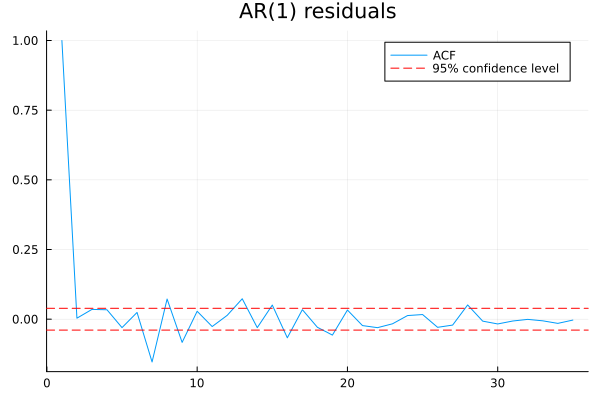

In [12]:
#Plot ACF of AR(1) residuals
plot_ACF(ARCHModels.residuals(ar1), "AR(1) residuals")

As can be seen, the coefficient of the first lag is significant and we have successfully modeled some dependencies. Nevertheless, there are still some significant dependecies left in the AR(1) residuals. Therefore, we will try estimating an ARMA(1,1) model.

In [13]:
#Fit ARMA(1,1)
arma11 = ARCHModels.fit(ARCHModels.ARMA{1,1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate   Std.Error    z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000636256  0.00028516   2.23122     0.0257
φ₁  -0.253836     0.261441    -0.97091     0.3316
θ₁   0.135427     0.254011     0.533154    0.5939
─────────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────────
      Estimate   Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
ω  0.000146814  1.74947e-5  8.39189    <1e-16
─────────────────────────────────────────────


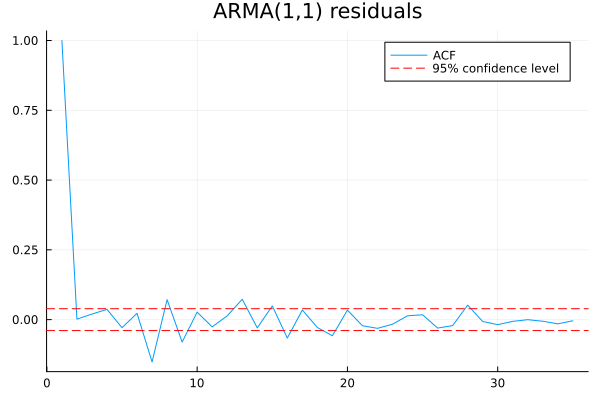

In [14]:
#Plot ACF of ARMA(1,1) residuals
plot_ACF(ARCHModels.residuals(arma11), "ARMA(1,1) residuals")

Since both the coefficients on AR(1) and MA(1) are insignificant and the improvement upon the AR(1) model is negligible, we will opt for the AR(1) model to avoid overfitting. We will hope to model the remaining dependencies using volatility modelling. Prior to estimating GARCH, we will verify the presence of ARCH effects using the LM test.

In [15]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(ARCHModels.residuals(ar1), 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          658.2

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   658.2


The LM test confirms the presence of ARCH effects in the AR(1) residuals. Therefore, we will estimate a GARCH model in the next step. As is common, we choose the GARCH(1,1) specification since it is very often sufficient to model the volatility. In addition, given the shape of the histogram of the returns, we assume a *t*-distribution to accomodate the heavy tails.

In [16]:
#Estimating GARCH
spec = ARCHModels.GARCH{1, 1}([0, .1, .08]) #Define the specifications and choose intial values for the coefficients
MCD_garch = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
ARCHModels.fit!(MCD_garch) #Fitting the model


GARCH{1, 1} model with Student's t errors, T=2516.

Mean equation parameters:
────────────────────────────────────────────────
       Estimate    Std.Error   z value  Pr(>|z|)
────────────────────────────────────────────────
c    0.00087085  0.000167953   5.18506    <1e-06
φ₁  -0.0470447   0.0198131    -2.37443    0.0176
────────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   6.39579e-6  2.97082e-6   2.15287    0.0313
β₁  0.854376    0.051674    16.534      <1e-60
α₁  0.0908529   0.0305248    2.97636    0.0029
──────────────────────────────────────────────

Distribution parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ν   4.21024   0.363053  11.5968    <1e-30
─────────────────────────────────────────


As can be seen, all the estimated coefficients are statistically significant. We can asses whether we successfully modelled the dependencies by inspecting the ACF plot.

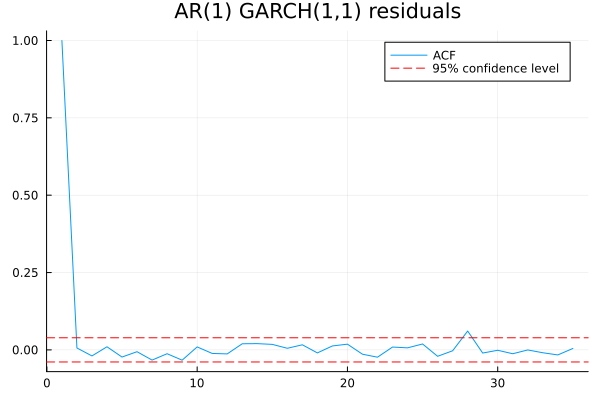

In [17]:
#Plot ACF for AR(1) GARCH(1,1) residuals
plot_ACF(ARCHModels.residuals(MCD_garch), "AR(1) GARCH(1,1) residuals")

The ACF plot suggests that the model residuals suffer from virtually no dependencies. We can further verify this by performing the ARCH test.

In [18]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(MCD_garch, 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          0.966188

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9954

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   0.966188


The p-value of the LM test is very high suggesting that there are no significant ARCH effects in the model residuals.

#### 4.

Now that we seem to have a reliable model, we can make forecasts and plot them. We will start with the fitted volatility values.

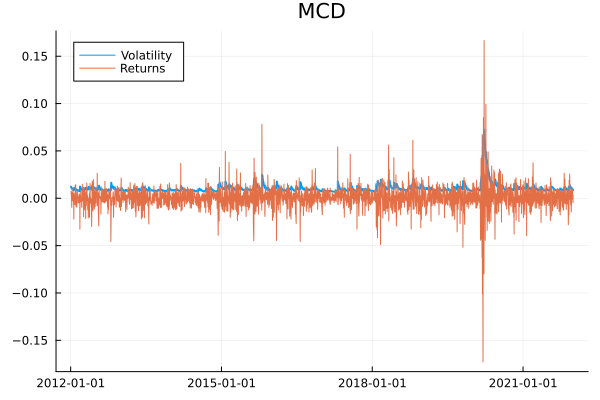

In [19]:
#Plot the fitted values
MCD_garch_vol = MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), ARCHModels.volatilities(MCD_garch))
Plots.plot(MCD_garch_vol, title = "MCD", legend = :topleft, label = "Volatility", lw = 2)
Plots.plot!(MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), MCD_log_ret), label = "Returns")


As can be seen, the model seems to at least partially capture some of the volatility clusters. In the next step we will perform out of sample forecasts using a rolling window.

In [20]:
#Making 1-step-ahead predictions on a rolling window
window_size = 500 #Specify the size of the rolling window
MCD_garch_vol_oot = Vector{Float64}(undef, length(MCD_log_ret) - window_size) #Initialize an empty vector for the forecasts
for i in 1:length(MCD_garch_vol_oot) #Loop through the rolling windows
    MCD_garch_rol = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret[i:(window_size + i - 1)]; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
    ARCHModels.fit!(MCD_garch) #Fit the model
    MCD_garch_vol_oot[i] = ARCHModels.predict(MCD_garch_rol)
end

Now we will compare the forecasted volatility with the fitted volatility.

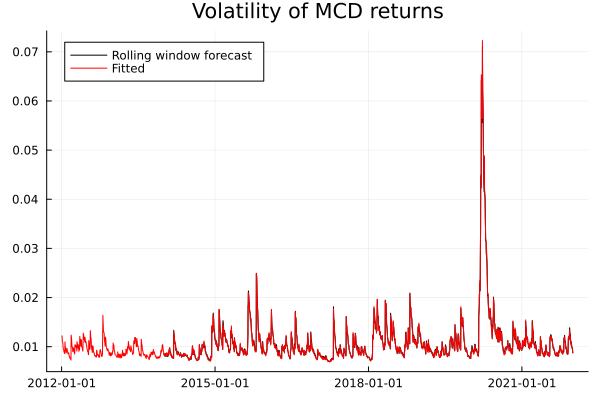

In [21]:
#Plot the predicted volatility vs. the fitted volatility
MCD_garch_vol_oot_timearray = MarketData.TimeArray(MarketData.timestamp(MCD_garch_vol[(window_size + 1):end]), MCD_garch_vol_oot) #Create a TimeArray from the volatility forecasts
Plots.plot(MCD_garch_vol_oot_timearray, title = "Volatility of MCD returns", label = "Rolling window forecast", legend = :topleft, c = :black)
Plots.plot!(MCD_garch_vol, label = "Fitted", c = :red)

As can be seen, there are some differences but the values are very similar. We can inspect the deviations further by plotting the difference of the two series.

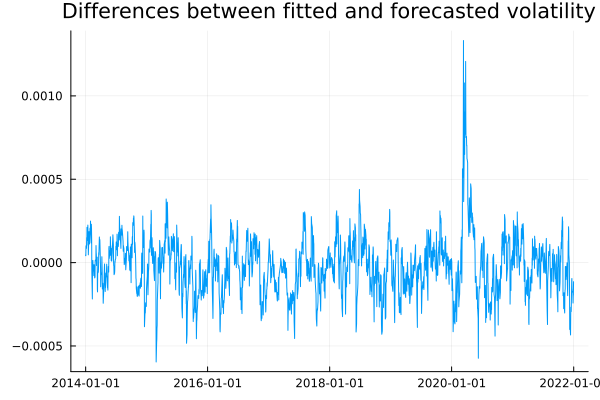

In [22]:
#Plot differences between fitted and forecasted volatility
Plots.plot(MCD_garch_vol[(window_size + 1):end] .- MCD_garch_vol_oot_timearray, title = "Differences between fitted and forecasted volatility", legend = false)

Even though the differences are very small, it appears that the fitted volatility is generally larger. We can also see that the greatest differences are in the first quarter of 2020 which may be associated with the coronavirus outbreak.

---

## Part B)

In this part we estimate the HAR model on the data provided at the seminar using various methods and then compare the results.

In [4]:
#Load data from the seminar
data_sem = CSV.read("PX_Ret_RV.csv", DataFrames.DataFrame; header=false);

In [6]:
#Calcualate RV 
target = data_sem[:, 3];

Next, we calculate the predictors for the HAR-RV model:

* Daily: $RV_{d_t} = RV_t$
* Weekly: $RV_{w_t} = \frac{1}{5}\sum_{i=0}^4RV_{t-i}$
* Monthly: $RV_{m_t} = \frac{1}{22}\sum_{i=0}^{22}RV_{t-i}$

As a target shall be used $RV_{t+1}$. Data are then split to train and test set. The former will be used for model development and the latter for evaluation. In addition, we standardize both sets using the mean and standard deviation of the training part to aid optimization.

*Note: `HAR_regressors()` taken from Seminar 3*

In [7]:
#Compute HAR regressors
predictors = HAR_regressors(target)

#Shift the target
target = target[23:end];

In [8]:
#Split into training and testing
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size)

#Standardization
mean_X_train = mapslices(StatsBase.mean, X_train; dims = 2) #Save the mean
std_X_train = mapslices(StatsBase.std, X_train; dims = 2) #Save the standard deviation
X_train = standardize(X_train) #Standardize the training set (using a custom define function from utils)
X_test = standardize(X_test); #Standardize the testing set (using mean and std of the training set)

Firstly, we will estimate the HAR coefficients using OLS. We define a loss function and find its minimum using gradient descent.

In [9]:
#OLS via Optim
OLS_optim = Optim.optimize(loss_HAR, [1., 1., 1., 1.], Optim.GradientDescent()) #Optimize the loss
OLS_optim.minimizer

4-element Vector{Float64}:
 7.807119329711047e-5
 3.711897965052052e-5
 4.475867493178716e-5
 1.7500010850307278e-5

We can compare the results of optimization with the analytical solution. As can be seen, the coefficients are virtually identical.

In [10]:
#Analytical OLS solution
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 7.80711932971107e-5
 3.71091635088338e-5
 4.4781513229560464e-5
 1.748719414366755e-5

Now that we have the coefficients, we can calculate the Mean Squared Error on the training and test sets.

In [11]:
#Calculating Mean Squared Error
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))

OLS train MSE: 9.149228986817107e-9
OLS test MSE: 8.690381094807229e-10


Curiously, the MSE is higher for the train set which suggests that the model in fact performs better on unseen data. As required, we also provide a QQ-plot of the residuals.

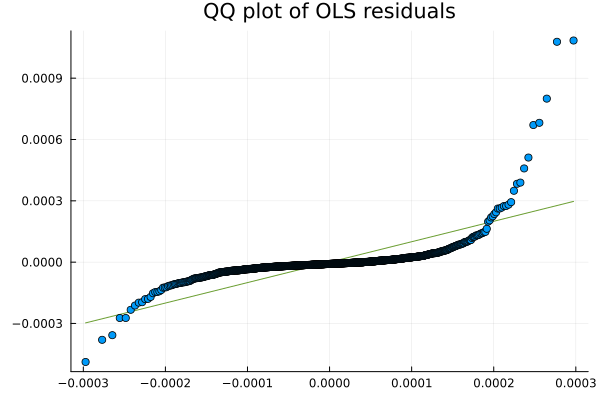

In [12]:
#QQ plot of OLS residuals
OLS_resid = transpose(y_train)[:,1] - calc_fitted(OLS_optim.minimizer, X_train)
StatsPlots.qqnorm(OLS_resid, title = "QQ plot of OLS residuals")

As the QQ plot shows, the distribution of the residuals from the HAR regression is very far from normal.

 Next, we will estimate a neural network with no hidden layer and the inputs being the HAR regressors. This should be equivalent to estimating a linear regression.

In [17]:
#NN estimation
Random.seed!(420) #Set the seed for reproducibility
model = Flux.Dense(3 => 1) #Define the specification
loss_HAR_NN(x, y) = Flux.Losses.mse(model(x), y) #Define the loss function
opt = Flux.Descent() #Specify the optimizer as gradient Descent
parameters = Flux.params(model) #Save the parameters to be estimated
data_train = [(X_train, y_train)] #Specify the training data
for epoch in 1:1000 #Train the model iteratively
    Flux.train!(loss_HAR_NN, parameters, data_train, opt) #Train
    epoch % 100 == 0 ? println("Epoch $epoch \t MSE (train): ", loss_HAR_NN(X_train, y_train), " \t MSE (test): ", loss_HAR_NN(X_test, y_test)) : nothing #Report the losses for each 20 epochs
end

Epoch 100 	 MSE (train): 0.00014738638 	 MSE (test): 9.112267e-6
Epoch 200 	 MSE (train): 5.2534426e-7 	 MSE (test): 3.23248e-8
Epoch 300 	 MSE (train): 1.0957897e-8 	 MSE (test): 9.645112e-10
Epoch 400 	 MSE (train): 9.155567e-9 	 MSE (test): 8.685012e-10
Epoch 500 	 MSE (train): 9.149252e-9 	 MSE (test): 8.689854e-10
Epoch 600 	 MSE (train): 9.149228e-9 	 MSE (test): 8.6903573e-10
Epoch 700 	 MSE (train): 9.149229e-9 	 MSE (test): 8.6903873e-10
Epoch 800 	 MSE (train): 9.149229e-9 	 MSE (test): 8.6903884e-10
Epoch 900 	 MSE (train): 9.149229e-9 	 MSE (test): 8.690389e-10
Epoch 1000 	 MSE (train): 9.149229e-9 	 MSE (test): 8.690389e-10


As can be seen, not only the train MSE decreases throughout the epochs but for the last 100 epochs it no longer further decreases which suggests that the optimization converged. We can now compare the MSEs with the values obtained via OLS.

In [18]:
#Compare the losses of OLS and ML
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))

OLS train MSE: 9.149228986817107e-9
OLS test MSE: 8.690381094807229e-10
ML train MSE: 9.149229e-9
ML test MSE: 8.690389e-10


The values are virtually the same. The same should apply to the estimated coefficients:

In [19]:
#Compare coefficients of OLS and ML
[OLS_optim.minimizer [model.bias; model.weight[1,:]]]

4×2 Matrix{Float64}:
 7.80712e-5  7.80712e-5
 3.7119e-5   3.71092e-5
 4.47587e-5  4.47815e-5
 1.75e-5     1.74872e-5

In the next step we will attempt to train a more sophisticated neural network to see if we can achieve a lower loss. For this purpose we have defined a generic function with a large number of parameters. We allow the presence of only a single hidden layer since it should be sufficient for approximation of any function. We will start by training a simple neural network with 3 hidden nodes and a ReLU activation function. We will use Gradient Descent for optimization.

In [22]:
#Train a neural network with 3 hidden nodes
NN_3_inits, NN_3 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 10000, learn_rate = 0.3);

Epoch 1000 	 MSE (train): 7.469063e-6 	 MSE (test): 5.659854e-6
Epoch 2000 	 MSE (train): 5.102244e-7 	 MSE (test): 4.886867e-7
Epoch 3000 	 MSE (train): 5.569199e-8 	 MSE (test): 4.2197993e-8
Epoch 4000 	 MSE (train): 1.9431969e-8 	 MSE (test): 6.631829e-9
Epoch 5000 	 MSE (train): 1.6273638e-8 	 MSE (test): 3.4961467e-9
Epoch 6000 	 MSE (train): 1.5966938e-8 	 MSE (test): 3.163142e-9
Early stopping at epoch 6460 	 MSE (train): 1.5944252e-8 	 MSE (test): 3.1354213e-9


After trying different learning rates and increasing the number of epochs, the testing loss does not appear to decrease any further. We can compare the losses with the previous models.

In [23]:
#Compare losses
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))
println("NN (3 nodes) train MSE: " * string(Flux.Losses.mse(NN_3(X_train), y_train)))
println("NN (3 nodes) test MSE: " * string(Flux.Losses.mse(NN_3(X_test), y_test)))

OLS train MSE: 9.149228986817107e-9
OLS test MSE: 8.690381094807229e-10
ML train MSE: 9.149229e-9
ML test MSE: 8.690389e-10
NN (3 nodes) train MSE: 1.5944252e-8
NN (3 nodes) test MSE: 3.1354213e-9


As we can see, the simpler models appear to outperform the more complex neural network. This may be a sign of overfitting. Before trying different parameter settings, we will compare the initial coefficients of the neural networks with their optimized counterparts.

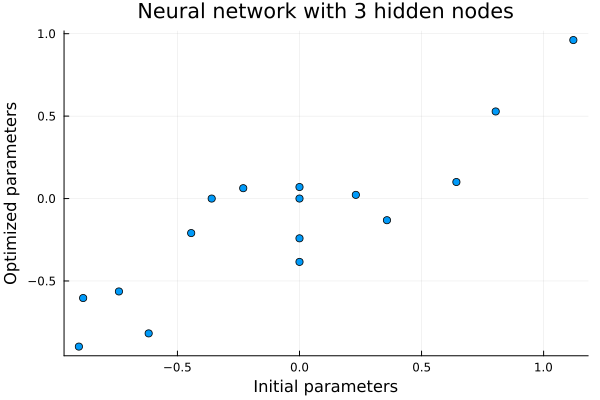

In [24]:
#Plot scatter of coefficients
Plots.scatter(NN_3_inits, extract_params(NN_3), legend = false, title = "Neural network with 3 hidden nodes", xlab = "Initial parameters", ylab = "Optimized parameters")

The scatter plot indicates that there is a clear linear relationship between the initial and optimized coefficients. This suggests that the initial values were not unreasonable. We will provide a histogram of the coefficients as well.

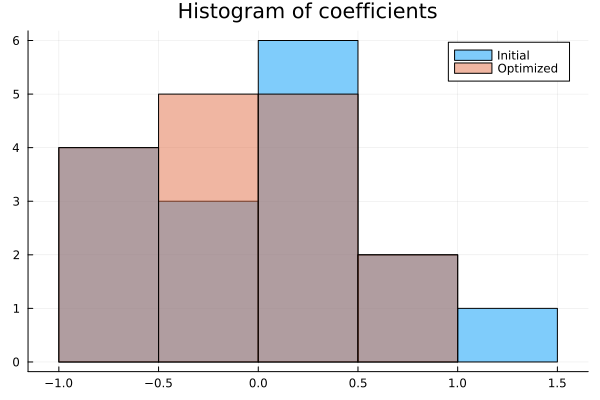

In [25]:
#Histogram of coefficients
Plots.histogram(NN_3_inits, title = "Histogram of coefficients", label = "Initial", bins = 8, fillalpha = 0.5)
Plots.histogram!(extract_params(NN_3), label = "Optimized", bins = 8, fillalpha = 0.5)

Similarly to to the scatter plot, the histograms shows that the distribution of the coefficients appear to be very similar. Nevertheless, we have estimated only 16 coefficients which seems to be an insufficient amount of observations to estimate the shape of a distribution. 

As we could see in the previous estimation, we did not manage to improve the loss of the OLS model. We will now attempt to surpass the perfomance by searching over a parameter grid. We have defined a devoted function which will estimate a neural network for each combination of the specified parameter grid. Apart from increasing the number of nodes, we also introduce two types of regularization (L2 and dropout). This might help to prevent overfitting. In addition, we try different learning rates, optimizers, and activation functions.

In [26]:
#Perform grid search (5m 29.7s)
param_grid = Dict(:nodes => [3, 7, 10], :learn_rate => [0.01, 0.1, 0.3], :α => [0, 0.1, 1], :dropout => [0, 0.2, 0.5], :opt => [Flux.Descent, Flux.Adam], :activ_func => [Flux.relu, Flux.tanh, Flux.sigmoid]) #Specify the parameter grid
gridsearch_res = gridSearch(param_grid, X_train, y_train, X_test, y_test; verbose = false);

Below we show the best 10 models according to MSE. As we can see, the first five models were able to achieve lower test MSE than OLS. This demonstrates the importance of hyperparameter boosting. The best model uses 7 nodes, the dropout regularization, and the sigmoid activation function.

In [27]:
#Show best 10 models
DataFrames.sort(gridsearch_res, :MSE)[begin:10,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,0.0,Descent,7,0.3,0.5,σ,8.21377e-10
2,1.0,Descent,7,0.01,0.0,σ,8.25258e-10
3,1.0,Descent,7,0.01,0.0,tanh,8.4774e-10
4,1.0,Descent,7,0.01,0.2,tanh,8.48273e-10
5,1.0,Descent,7,0.01,0.5,tanh,8.49869e-10
6,1.0,Descent,10,0.01,0.2,relu,8.69173e-10
7,1.0,Descent,10,0.01,0.0,relu,8.6921e-10
8,1.0,Descent,10,0.01,0.5,relu,8.69401e-10
9,1.0,Descent,7,0.1,0.0,tanh,8.78645e-10


We can take a look at the QQ plot of the residuals of the best model.

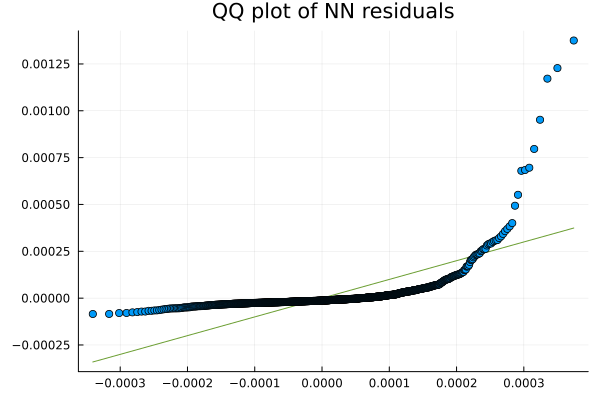

In [28]:
#QQ plot of residuals of the best model
best_model = train_NN(X_train, y_train, X_test, y_test; α = 0, opt = Flux.Descent, nodes = 7, learn_rate = 0.3, dropout = 0.5, activ_func = Flux.sigmoid, return_inits = false, verbose = false) #Reestimate the model with best parameters
best_model_resid = y_train - best_model(X_train) #Calculate residuals
StatsPlots.qqnorm(best_model_resid[1,:], title = "QQ plot of NN residuals")

Even for the best NN model, the distribution of the residuals is still far from normal. Lastly, we will plot the predicted Realized Volatility.

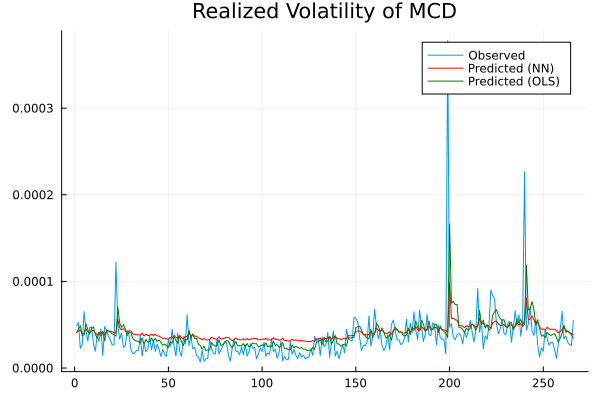

In [29]:
#Plot predictions of the best NN model
Plots.plot(y_test[1, :], title = "Realized Volatility of MCD", label = "Observed")
Plots.plot!(best_model(X_test)[1,:], label = "Predicted (NN)", c = :red)
Plots.plot!(calc_fitted(OLS_optim.minimizer, X_test), label = "Predicted (OLS)", c = :green)

As can be seen, both the OLS and the NN appear to predict the Realized Volatility in a similar way. Nevertheless, OLS appears to capture the large cluster better. The NN predictions appear more smooth.

---

# Part C)

In part C, we extend our work from part B. Therefore, our aim is to predict the Realized volatility of the PX index using Machine Learning methods. Optimally, we would like to outperform the simple OLS-HAR approach, which is known to be hard to beat.

Previously, we implemented a Feed Forward Neural Network and a hyperparameter optimization process (grid search) to find the best possible NN. Here, we expand our work by adding an ensemble averaging method to achieve ideally lower error than while using a single NN. In addition, we evaluate the performance using cross-validation. Further, we compare the results with a Recurrent Neural Network.

We start by estimating three Neural Networks with the optimal parameters found using the grid search in part B). We consider the three best models (according to MSE) and their parameters.

In [43]:
#Estimate three separate models with the previously found optimal parameters
best_model_2 = train_NN(X_train, y_train, X_test, y_test; α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.01, dropout = 0, activ_func = Flux.sigmoid, return_inits = false, verbose = false)
best_model_3 = train_NN(X_train, y_train, X_test, y_test; α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.01, dropout = 0, activ_func = Flux.tanh, return_inits = false, verbose = false);

We estimated the second best and third best model (we have the best one from part B) and now we can average their predictions. We use uniform weights.

In [44]:
#Use the average prediction of all three models and calculate the resulting loss on the test set
ensemble_NN = get_ensemble(X_train, y_train, X_test, y_test, [best_model, best_model_2, best_model_3], weights = [1,1,1]);

Score of each model from the ensemble:
MSE (train): 1.3513234e-8 	 MSE (test): 8.2137736e-10
MSE (train): 1.2344372e-8 	 MSE (test): 8.252584e-10
MSE (train): 1.8225046e-8 	 MSE (test): 8.4774027e-10
Score of the ensemble:
MSE (train): 1.431957067637851e-8 	 MSE (test): 8.163955546553151e-10


Indeed, in the example above, the equally weighted ensamble of three networks achieves a better test set MSE (8.16396e-10) than each network individually.

So far, we have evaluated the models' perfomance using only a single test set. Since the MSE of the test set might not be entirely representative of the models' generalization power, we also implement Cross-Validation to evaluate the models' performance. In this way we compare the previously found best three models.

In [47]:
#4-fold Cross-validation of the best 3 models
#cross_validate(X_train, y_train, folds = 3,  test_size = 0.8, α = 0, opt = Flux.Descent, nodes = 7, learn_rate = 0.3, dropout = 0.5, activ_func = Flux.sigmoid, return_inits = false, verbose = false);
cross_validate(X_train, y_train, folds = 4,  test_size = 0.8, α = 0, opt = Flux.Descent, nodes = 7, learn_rate = 0.3, dropout = 0.5, activ_func = Flux.sigmoid, return_inits = false, verbose = false)
cross_validate(X_train, y_train, folds = 4,  test_size = 0.8, α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.01, dropout = 0, activ_func = Flux.sigmoid, return_inits = false, verbose = false)
cross_validate(X_train, y_train, folds = 4,  test_size = 0.8, α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.01, dropout = 0, activ_func = Flux.tanh, return_inits = false, verbose = false);

Fold 1/4, Out-of-sample MSE: 1.6022712e-8
Fold 2/4, Out-of-sample MSE: 9.062474e-7
Fold 3/4, Out-of-sample MSE: 3.8393573e-5
Fold 4/4, Out-of-sample MSE: 1.765356e-7
Cross-validation done. Average MSE: 9.873095e-6
Fold 1/4, Out-of-sample MSE: 2.4237197e-8
Fold 2/4, Out-of-sample MSE: 1.8721245e-9
Fold 3/4, Out-of-sample MSE: 5.7840244e-10
Fold 4/4, Out-of-sample MSE: 6.9753764e-10
Cross-validation done. Average MSE: 6.8463155e-9
Fold 1/4, Out-of-sample MSE: 6.230808e-8
Fold 2/4, Out-of-sample MSE: 4.544227e-9
Fold 3/4, Out-of-sample MSE: 3.3295753e-5
Fold 4/4, Out-of-sample MSE: 7.2139594e-10
Cross-validation done. Average MSE: 8.340831e-6


As we can see, the best model according to cross-validation appears to be the second one. This shows the importance of cross-validation. Ideally, one would perform grid search in combination with cross-validation. We did not implement this kind of procedure due to the time complexity. 

As an additional contender we estimate a Recurrent Neural Network. As for the FFNN we perform hyperparameter grid search to find the best model. Given the increased complexity, we decrease the number of epochs to 100.

In [ ]:
#Perform grid search (10m 51.3s)
X_train_RNN = reshape(X_train, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_train_RNN = reshape(y_train, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
X_test_RNN = reshape(X_test, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_test_RNN = reshape(y_test, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
gridsearch_RNN_res = gridSearch(param_grid, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN; verbose = false, func = train_RNN);

Below we show the best 10 models. As can be seen, we managed to surpass OLS even with mere 100 epochs. Furthermore, the best RNN model surpasses even the best NN model. This is achieved using the *relu* activation function, heavy L2 and dropout regularization and a quite high learning rate. The gradient descent optimizer seems to outperform Adam even for RNN.

In [48]:
#Show best 10 models
DataFrames.sort(gridsearch_RNN_res, :MSE)[begin:10,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,7,0.1,0.2,relu,7.84206e-10
2,1.0,Descent,7,0.1,0.0,σ,8.08358e-10
3,1.0,Descent,7,0.1,0.2,tanh,8.28756e-10
4,1.0,Descent,7,0.1,0.0,tanh,8.30652e-10
5,1.0,Descent,7,0.1,0.5,tanh,8.31554e-10
6,1.0,Descent,10,0.1,0.0,tanh,8.31984e-10
7,1.0,Descent,7,0.1,0.5,relu,8.35269e-10
8,1.0,Descent,10,0.1,0.2,tanh,8.36063e-10
9,1.0,Descent,3,0.1,0.0,σ,8.36477e-10


Let us now reestimate the best model with a greater number of epochs to see whether we can further decrease the test loss.

In [49]:
#Reestimate best RNN
best_RNN = train_RNN(X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN; α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.1, dropout = 0.2, activ_func = Flux.relu, n_epochs = 1000, return_inits = false, verbose = true);

Early stopping at epoch 30. 	 Final MSE (test): 7.84206e-10


As can be seen, the algorithm converges after the 30th epoch so increasing the number of epochs has no impact. As for the NN, now we attempt to use ensemblimg to improve the MSE of the best model.

In [50]:
#Estimate additional best RNNs
best_RNN_2 = train_RNN(X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN; α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.1, dropout = false, activ_func = Flux.sigmoid, n_epochs = 1000, return_inits = false, verbose = false);
best_RNN_3 = train_RNN(X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN; α = 1, opt = Flux.Descent, nodes = 7, learn_rate = 0.1, dropout = 0.2, activ_func = Flux.tanh, n_epochs = 1000, return_inits = false, verbose = false);

In [51]:
#Ensemble best 3 RNN models
ensemble_RNN = get_ensemble_RNN(X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, [best_RNN, best_RNN_2, best_RNN_3], weights = [1,1,1]);

Score of each model from the ensemble:
MSE (train): 1.2035758e-8 	 MSE (test): 7.8420614e-10
MSE (train): 1.0701024e-8 	 MSE (test): 8.083583e-10
MSE (train): 1.5770192e-8 	 MSE (test): 8.2875595e-10
Score of the ensemble:
MSE (train): 1.2503961243517168e-8 	 MSE (test): 7.912416078043014e-10


In this case, ensembling does not seem to help even though it is very close to the best model. Let us now plot the predicted Realized Volatility.

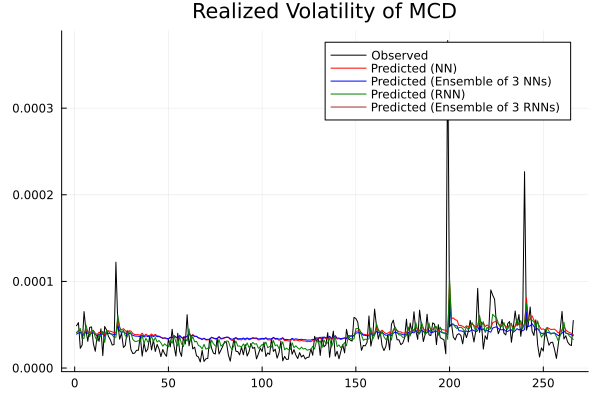

In [53]:
#Plot volatility
Plots.plot(y_test[1, :], title = "Realized Volatility of MCD", label = "Observed", c = :black)
Plots.plot!(best_model(X_test)[1,:], label = "Predicted (NN)", c = :red)
Plots.plot!(ensemble_NN[2][1,:], label = "Predicted (Ensemble of 3 NNs)", c = :blue)
Flux.reset!(best_RNN) #Reset the hidden state
best_RNN(X_train_RNN) #Prepare the hidden state for predictions
Plots.plot!(best_RNN(X_test_RNN)[1,1,:], label = "Predicted (RNN)", c = :green)
Plots.plot!(ensemble_RNN[2][1,:], label = "Predicted (Ensemble of 3 RNNs)", c = :brown)


As the plot shows, the RNN appears to predict the volatility much better than NN.